In [2]:
import pandas as pd
import requests
from datetime import datetime, timedelta, date
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

Referenced links for generating price through APIs

* https://docs.ftx.com/?python#get-trades

* https://algotrading101.com/learn/ftx-api-guide/

* https://www.epochconverter.com/

In [3]:
markets = requests.get('https://ftx.com/api/markets').json()
market_df = pd.DataFrame(markets['result'])
market_df_name_indexed = market_df.set_index('name')
# market_df_name_indexed.T

## Finding for active Perpetual futures (by vol)

In [5]:
futures_name_list = list(filter(lambda x: 'PERP' in x, list(market_df_name_indexed.T.columns)))
futures_active = market_df[market_df['name'].isin(futures_name_list) & market_df['quoteVolume24h'].apply(lambda x: x > 10**7)]
futures_active.sort_values(by = 'quoteVolume24h', ascending = False,inplace = True)
futures_active.reset_index(drop=True, inplace=True)
futures_active_name_list = list(futures_active['name'])
futures_active_name_list[:6]

C:\Users\Dell\AppData\Local\Temp/ipykernel_17876/2894392785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  futures_active.sort_values(by = 'quoteVolume24h', ascending = False,inplace = True)


['ETH-PERP', 'BTC-PERP', 'SOL-PERP', 'ETC-PERP', 'MATIC-PERP', 'DOGE-PERP']

### Top 10 solely based on 24hr Volume

In [5]:
futures_active_top_10_list = futures_active_name_list[:10]
futures_active_top_10_dct = {}
for i in futures_active_top_10_list:
    futures_active_top_10_dct[i] = ''

### Top 15 based on start date and 24hr Volume

In [9]:
futures_active_and_longstanding_top_15_list = []
for key in futures_active_name_list:
    market = key.split('-')[0]
    min_datetime = min(pd.DataFrame(requests.get(f"https://ftx.com/api/indexes/{market}/candles?resolution={86400}").json()['result'])['startTime'])
    min_date = min_datetime.split('T')[0]
    if key == 'USDT-PERP':
        print(f'Reject - {key}')
        continue
    elif pd.to_datetime(min_date) <= pd.to_datetime('2021-03-01'):
        print(f'{key}: {min_date}')
        futures_active_and_longstanding_top_15_list.append(key)
    else:
        print(f'Reject - {key}: {min_date}')
    if len(futures_active_and_longstanding_top_15_list) == 15:
        break

ETH-PERP: 2019-03-03
BTC-PERP: 2019-03-03
SOL-PERP: 2020-07-26
ETC-PERP: 2019-09-03
MATIC-PERP: 2019-10-22
DOGE-PERP: 2019-10-21
ADA-PERP: 2019-10-23
AVAX-PERP: 2020-09-22
CEL-PERP: 2021-01-02
Reject - SAND-PERP: 2021-03-22
Reject - OP-PERP: 2022-06-01
BNB-PERP: 2019-05-09
Reject - APE-PERP: 2022-03-17
Reject - USDT-PERP
LINK-PERP: 2019-10-15
Reject - KSHIB-PERP: 2021-10-27
Reject - GMT-PERP: 2022-03-16
CHZ-PERP: 2020-10-18
NEAR-PERP: 2021-02-21
DOT-PERP: 2020-07-18
CRV-PERP: 2021-01-08


# TOP 15 (Part 1)

## 5 Minute data collection (Top 15)

In [42]:
futures_active_top_15_list = futures_active_and_longstanding_top_15_list
futures_active_top_15_dct = {}
for i in futures_active_and_longstanding_top_15_list:
    futures_active_top_15_dct[i] = ''

In [28]:
start = 1614556800
end = 1659916800
timing_chunk = list(range(start, end, 5000*60*5))
btc_df = pd.DataFrame()
for duration in timing_chunk:
    start = duration
    end = duration + (5000*300) - 1
    historical = requests.get(f'https://ftx.com/api/markets/BTC-PERP/candles?resolution=300&start_time={start}&end_time={end}&limit=5005').json()
    historical = pd.DataFrame(historical['result'])
    btc_df = pd.concat([btc_df, historical], axis = 0)
btc_df.shape

(151638, 7)

In [29]:
# Ensuring flow of hours were successful
(btc_df['startTime'].apply(lambda x: pd.to_datetime(x)) - btc_df['startTime'].shift(1).apply(lambda x: pd.to_datetime(x))).value_counts()

0 days 00:05:00    151631
0 days 00:10:00         6
Name: startTime, dtype: int64

In [43]:
start = 1614556800
end = 1659916800
timing_chunk = list(range(start, end, 5000*90*10))
active_futures_pricing_data = pd.DataFrame()

for key in futures_active_top_15_list:
    temp = pd.DataFrame()
    for duration in timing_chunk:
        start = duration
        end = duration + (5000*900) - 1
        historical = requests.get(f'https://ftx.com/api/markets/{key}/candles?resolution=900&start_time={start}&end_time={end}&limit=5005').json()
        historical = pd.DataFrame(historical['result'])
        temp = pd.concat([temp, historical], axis = 0)
    futures_active_top_15_dct[key] = temp.copy()

In [44]:
futures_active_top_15_dct.keys()

dict_keys(['ETH-PERP', 'BTC-PERP', 'SOL-PERP', 'AVAX-PERP', 'ETC-PERP', 'MATIC-PERP', 'BNB-PERP', 'LINK-PERP', 'DOT-PERP', 'NEAR-PERP', 'ADA-PERP', 'DOGE-PERP', 'ATOM-PERP', 'ZEC-PERP', 'FTM-PERP'])

In [45]:
temp_dct = futures_active_top_15_dct.copy()

In [46]:
for key, value in futures_active_top_15_dct.items():
    naming = f'Datasets/5 minute pricing/{key}_5_minute_pricing.csv'
    temp_df = value.copy()
    temp_df.to_csv(naming, index = False)

## Working on overall 5 minute pricing data (Top 15)

In [47]:
# active_top_10_minute_volume = pd.DataFrame(futures_active_top_10_dct['BTC-PERP'][['startTime', 'volume']])
# active_top_10_minute_volume.columns = ['startTime','BTC_volume']
active_top_15_5min_price = pd.DataFrame(futures_active_top_15_dct['BTC-PERP'][['startTime', 'open']])
active_top_15_5min_price.columns = ['startTime','BTC_price']

for key, value in futures_active_top_15_dct.items():
    if key == 'BTC-PERP':
        continue
    else:
        name = key.split('-')[0]
        # temp_volume_df = value[['startTime', 'volume']]
        # temp_volume_df.columns = ['startTime', f'{name}_vol']
        temp_price_df = value[['startTime', 'open']]
        temp_price_df.columns = ['startTime', f'{name}_price']
        if len(temp_price_df) != len(temp_price_df):
            print('Different length error')
            continue
        else:
            # active_top_10_hour_volume = active_top_10_hour_volume.merge(temp_volume_df, on='startTime', how = 'inner')
            active_top_15_5min_price = active_top_15_5min_price.merge(temp_price_df, on='startTime', how = 'inner')
            # active_top_10_minute_volume = pd.concat([active_top_10_minute_volume, temp_volume_df], axis = 1)
            # active_top_10_minute_price = pd.concat([active_top_10_minute_price, temp_open_df], axis = 1)

# active_top_10_minute_price.to_csv('Datasets/minute pricing/overall_top_10_active_minute_pricing.csv', index=False)
# active_top_10_minute_volume.to_csv('Datasets/minute pricing/overall_top_10_active_minute_volume.csv', index=False)

In [48]:
active_top_15_5min_price.head(3)

,startTime,BTC_price,ETH_price,SOL_price,AVAX_price,ETC_price,MATIC_price,BNB_price,LINK_price,DOT_price,NEAR_price,ADA_price,DOGE_price,ATOM_price,ZEC_price,FTM_price
0,2021-03-09T10:30:00+00:00,54238.0,1830.1,14.3900,28.571,12.0630,0.245550,273.8800,31.386,36.380,5.2605,1.172570,0.057854,20.2820,134.84,0.47890
1,2021-03-09T10:45:00+00:00,54138.0,1824.4,14.2900,28.015,12.0085,0.248578,274.1250,31.237,36.281,5.4745,1.209985,0.057520,20.0620,134.23,0.47205
2,2021-03-09T11:00:00+00:00,54270.0,1828.5,14.3875,28.234,12.1025,0.248225,272.0125,31.264,36.217,5.6045,1.193535,0.057592,20.0735,135.34,0.47025


#### price

<AxesSubplot:>

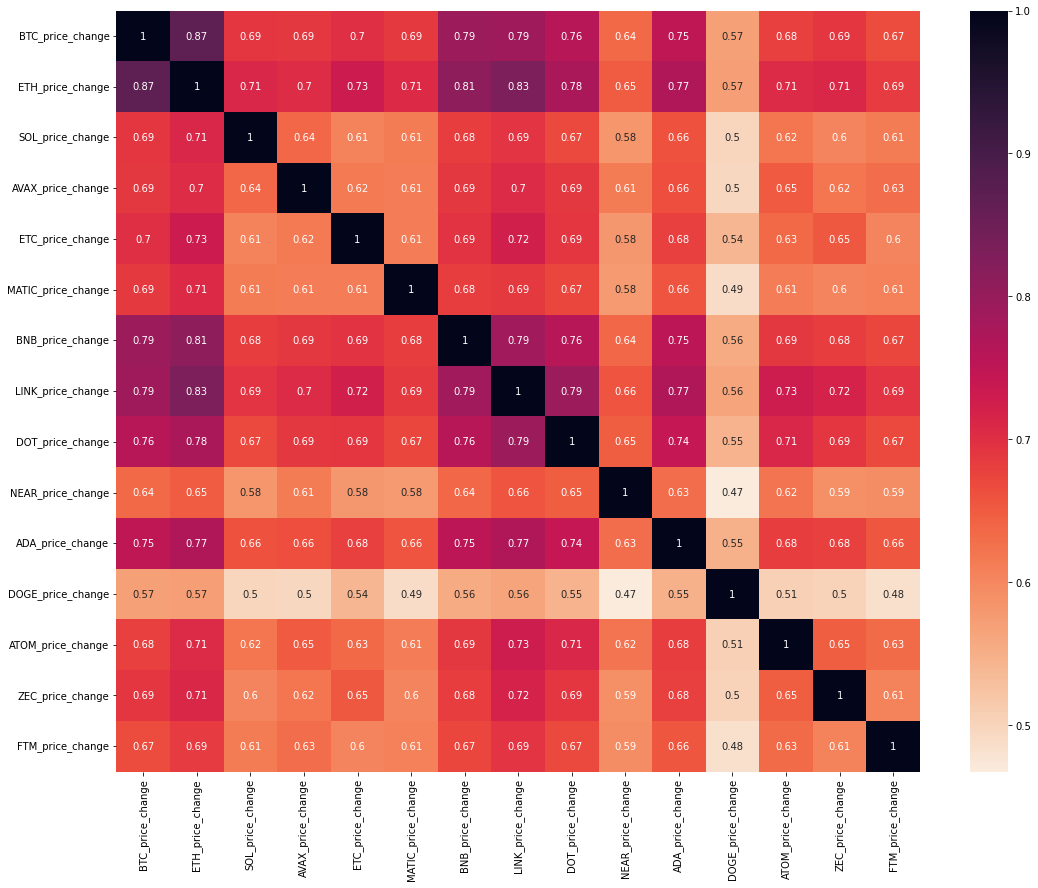

In [49]:
active_top_15_5min_price_change = pd.DataFrame(active_top_15_5min_price.loc[1:,'startTime'])
price_col_names = list(active_top_15_5min_price.columns)[1:]
for name in price_col_names:
    active_top_15_5min_price_change[f'{name}_change'] = pd.Series(active_top_15_5min_price[name].pct_change(1))[1:]

plt.figure(figsize=(18, 14))
sns.heatmap(active_top_15_5min_price_change.corr(), annot = True, cmap = sns.cm.rocket_r)

## 15 Minute data collection (Top 15)

In [111]:
futures_active_top_15_list = futures_active_and_longstanding_top_15_list
futures_active_top_15_dct = {}
for i in futures_active_and_longstanding_top_15_list:
    futures_active_top_15_dct[i] = ''

In [110]:
start = 1614556800
end = 1659916800
timing_chunk = list(range(start, end, 5000*60*15))
btc_df = pd.DataFrame()
for duration in timing_chunk:
    start = duration
    end = duration + (5000*900) - 1
    historical = requests.get(f'https://ftx.com/api/markets/BTC-PERP/candles?resolution=900&start_time={start}&end_time={end}&limit=5005').json()
    historical = pd.DataFrame(historical['result'])
    btc_df = pd.concat([btc_df, historical], axis = 0)
btc_df.shape

(50546, 7)

In [103]:
# Ensuring flow of hours were successful
(btc_df['startTime'].apply(lambda x: pd.to_datetime(x)) - btc_df['startTime'].shift(1).apply(lambda x: pd.to_datetime(x))).value_counts()

0 days 00:15:00    50544
Name: startTime, dtype: int64

In [112]:
start = 1614556800
end = 1659916800
timing_chunk = list(range(start, end, 5000*90*10))
active_futures_pricing_data = pd.DataFrame()

for key in futures_active_top_15_list:
    temp = pd.DataFrame()
    for duration in timing_chunk:
        start = duration
        end = duration + (5000*900) - 1
        historical = requests.get(f'https://ftx.com/api/markets/{key}/candles?resolution=900&start_time={start}&end_time={end}&limit=5005').json()
        historical = pd.DataFrame(historical['result'])
        temp = pd.concat([temp, historical], axis = 0)
    futures_active_top_15_dct[key] = temp.copy()

In [113]:
temp_dct = futures_active_top_15_dct.copy()

In [114]:
for key, value in futures_active_top_15_dct.items():
    naming = f'Datasets/15 minute pricing/{key}_15_minute_pricing.csv'
    temp_df = value.copy()
    temp_df.to_csv(naming, index = False)

## Working on overall 15 minute pricing data (Top 15)

In [118]:
# active_top_10_minute_volume = pd.DataFrame(futures_active_top_10_dct['BTC-PERP'][['startTime', 'volume']])
# active_top_10_minute_volume.columns = ['startTime','BTC_volume']
active_top_15_15min_price = pd.DataFrame(futures_active_top_15_dct['BTC-PERP'][['startTime', 'open']])
active_top_15_15min_price.columns = ['startTime','BTC_price']

for key, value in futures_active_top_15_dct.items():
    if key == 'BTC-PERP':
        continue
    else:
        name = key.split('-')[0]
        # temp_volume_df = value[['startTime', 'volume']]
        # temp_volume_df.columns = ['startTime', f'{name}_vol']
        temp_price_df = value[['startTime', 'open']]
        temp_price_df.columns = ['startTime', f'{name}_price']
        if len(temp_price_df) != len(temp_price_df):
            print('Different length error')
            continue
        else:
            # active_top_10_hour_volume = active_top_10_hour_volume.merge(temp_volume_df, on='startTime', how = 'inner')
            active_top_15_15min_price = active_top_15_15min_price.merge(temp_price_df, on='startTime', how = 'inner')
            # active_top_10_minute_volume = pd.concat([active_top_10_minute_volume, temp_volume_df], axis = 1)
            # active_top_10_minute_price = pd.concat([active_top_10_minute_price, temp_open_df], axis = 1)

# active_top_10_minute_price.to_csv('Datasets/minute pricing/overall_top_10_active_minute_pricing.csv', index=False)
# active_top_10_minute_volume.to_csv('Datasets/minute pricing/overall_top_10_active_minute_volume.csv', index=False)

In [126]:
active_top_15_15min_price.head(3)

,startTime,BTC_price,ETH_price,SOL_price,AVAX_price,ETC_price,MATIC_price,BNB_price,NEAR_price,DOT_price,LINK_price,ADA_price,DOGE_price,ATOM_price,ZEC_price,FTM_price
0,2021-03-09T10:30:00+00:00,54238.0,1830.1,14.3900,28.571,12.0630,0.245550,273.8800,5.2605,36.380,31.386,1.172570,0.057854,20.2820,134.84,0.47890
1,2021-03-09T10:45:00+00:00,54138.0,1824.4,14.2900,28.015,12.0085,0.248578,274.1250,5.4745,36.281,31.237,1.209985,0.057520,20.0620,134.23,0.47205
2,2021-03-09T11:00:00+00:00,54270.0,1828.5,14.3875,28.234,12.1025,0.248225,272.0125,5.6045,36.217,31.264,1.193535,0.057592,20.0735,135.34,0.47025


#### price

<AxesSubplot:>

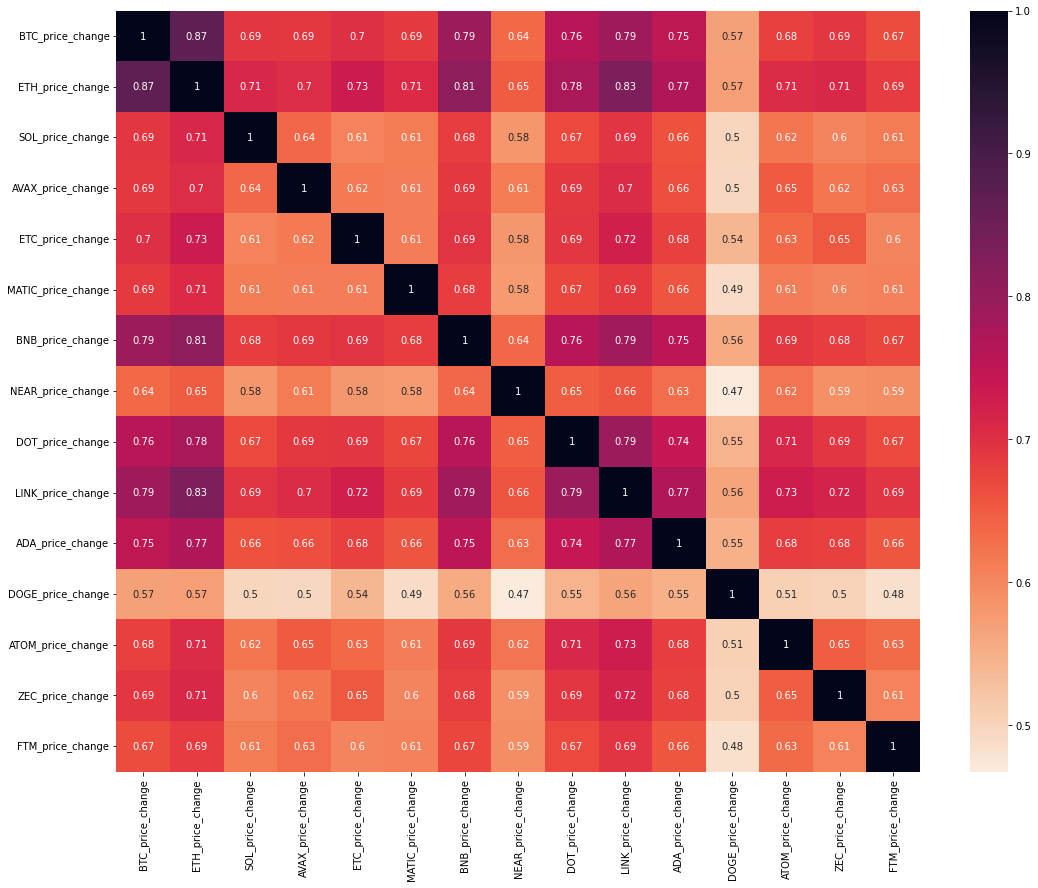

In [138]:
active_top_15_15min_price_change = pd.DataFrame(active_top_15_15min_price.loc[1:,'startTime'])
price_col_names = list(active_top_15_15min_price.columns)[1:]
for name in price_col_names:
    active_top_15_15min_price_change[f'{name}_change'] = pd.Series(active_top_15_15min_price[name].pct_change(1))[1:]

plt.figure(figsize=(18, 14))
sns.heatmap(active_top_15_15min_price_change.corr(), annot = True, cmap = sns.cm.rocket_r)

#### ln price (No diff from just percentage different)

<AxesSubplot:>

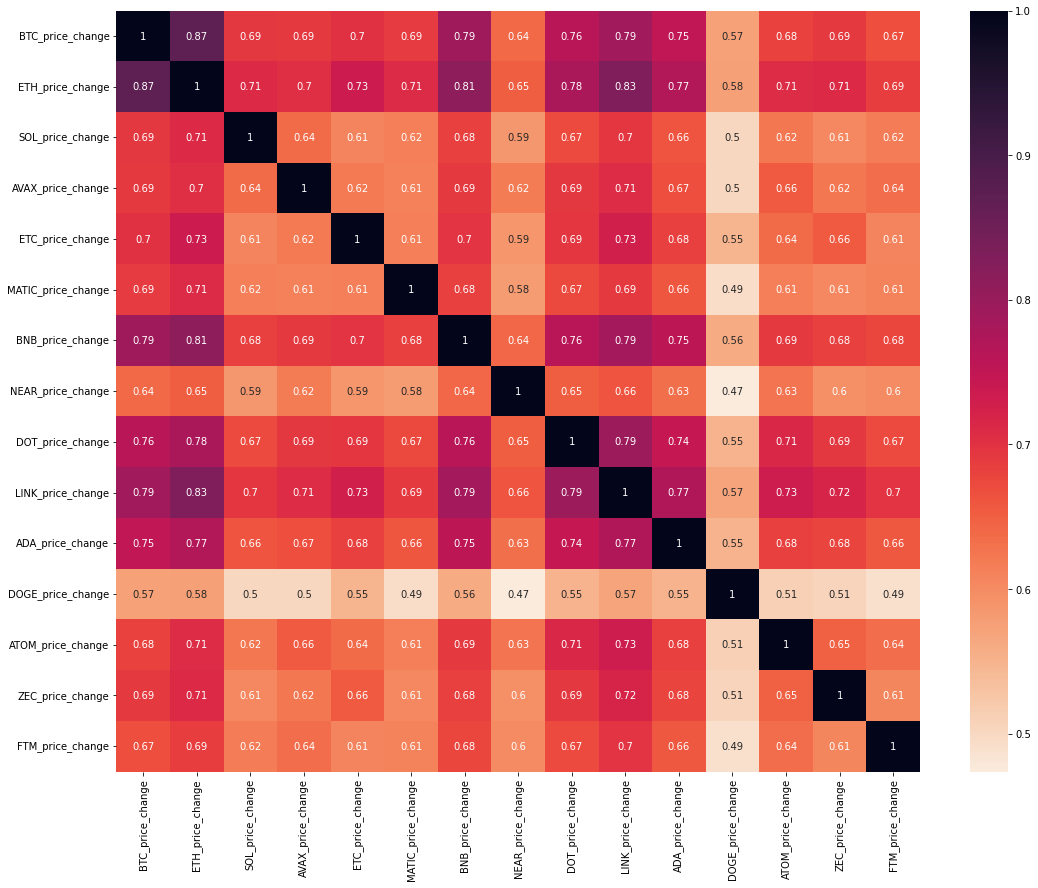

In [139]:
active_top_15_15min_price_ln_change = pd.DataFrame(active_top_15_15min_price.loc[1:,'startTime'])
price_col_names = list(active_top_15_15min_price.columns)[1:]
for name in price_col_names:
    active_top_15_15min_price_ln_change[f'{name}_change'] = pd.Series(np.log(active_top_15_15min_price[name]/active_top_15_15min_price[name].shift(1)))[1:]

plt.figure(figsize=(18, 14))
sns.heatmap(active_top_15_15min_price_ln_change.corr(), annot = True, cmap = sns.cm.rocket_r)

## Hour data collection (Top 15)

In [15]:
futures_active_top_15_dct = {}
for i in futures_active_and_longstanding_top_15_list:
    futures_active_top_15_dct[i] = ''

In [10]:
start = 1577836800
end = 1660488330
timing_chunk = list(range(start, end, 5000*3600))
btc_df = pd.DataFrame()
for duration in timing_chunk:
    start = duration
    end = duration + (5000*3600) - 1
    historical = requests.get(f'https://ftx.com/api/markets/BTC-PERP/candles?resolution=3600&start_time={start}&end_time={end}&limit=5005').json()
    historical = pd.DataFrame(historical['result'])
    btc_df = pd.concat([btc_df, historical], axis = 0)
btc_df.shape

(22959, 7)

In [11]:
# Ensuring flow of hours were successful
(btc_df['startTime'].apply(lambda x: pd.to_datetime(x)) - btc_df['startTime'].shift(1).apply(lambda x: pd.to_datetime(x))).value_counts()

0 days 01:00:00    22958
Name: startTime, dtype: int64

In [16]:
start = 1577836800
end = 1659916800
timing_chunk = list(range(start, end, 5000*3600))
active_futures_pricing_data = pd.DataFrame()

for key in futures_active_and_longstanding_top_15_list:
    temp = pd.DataFrame()
    for duration in timing_chunk:
        start = duration
        end = duration + (5000*3600) - 1
        historical = requests.get(f'https://ftx.com/api/markets/{key}/candles?resolution=3600&start_time={start}&end_time={end}&limit=5005').json()
        historical = pd.DataFrame(historical['result'])
        temp = pd.concat([temp, historical], axis = 0)
    futures_active_top_15_dct[key] = temp.copy()

In [17]:
temp_dct = futures_active_top_15_dct.copy()

In [19]:
for key, value in futures_active_top_15_dct.items():
    naming = f'Datasets/hour pricing/{key}_hour_pricing.csv'
    temp_df = value.copy()
    temp_df.to_csv(naming, index = False)

## Working on overall hour pricing data (Top 15)

In [20]:
futures_active_top_15_dct.keys()

dict_keys(['ETH-PERP', 'BTC-PERP', 'SOL-PERP', 'ETC-PERP', 'MATIC-PERP', 'DOGE-PERP', 'ADA-PERP', 'AVAX-PERP', 'CEL-PERP', 'BNB-PERP', 'LINK-PERP', 'CHZ-PERP', 'NEAR-PERP', 'DOT-PERP', 'CRV-PERP'])

In [21]:
# active_top_10_minute_volume = pd.DataFrame(futures_active_top_10_dct['BTC-PERP'][['startTime', 'volume']])
# active_top_10_minute_volume.columns = ['startTime','BTC_volume']
active_top_15_hour_price = pd.DataFrame(futures_active_top_15_dct['BTC-PERP'][['startTime', 'open']])
active_top_15_hour_price.columns = ['startTime','BTC_price']

for key, value in futures_active_top_15_dct.items():
    if key == 'BTC-PERP':
        continue
    else:
        name = key.split('-')[0]
        # temp_volume_df = value[['startTime', 'volume']]
        # temp_volume_df.columns = ['startTime', f'{name}_vol']
        temp_price_df = value[['startTime', 'open']]
        temp_price_df.columns = ['startTime', f'{name}_price']
        if len(temp_price_df) != len(temp_price_df):
            print('Different length error')
            continue
        else:
            # active_top_10_hour_volume = active_top_10_hour_volume.merge(temp_volume_df, on='startTime', how = 'inner')
            active_top_15_hour_price = active_top_15_hour_price.merge(temp_price_df, on='startTime', how = 'inner')
            # active_top_10_minute_volume = pd.concat([active_top_10_minute_volume, temp_volume_df], axis = 1)
            # active_top_10_minute_price = pd.concat([active_top_10_minute_price, temp_open_df], axis = 1)

# active_top_10_minute_price.to_csv('Datasets/minute pricing/overall_top_10_active_minute_pricing.csv', index=False)
# active_top_10_minute_volume.to_csv('Datasets/minute pricing/overall_top_10_active_minute_volume.csv', index=False)

In [22]:
active_top_15_hour_price.head(2)

,startTime,BTC_price,ETH_price,SOL_price,ETC_price,MATIC_price,DOGE_price,ADA_price,AVAX_price,CEL_price,BNB_price,LINK_price,CHZ_price,NEAR_price,DOT_price,CRV_price
0,2021-06-10T07:00:00+00:00,36792.0,2542.2,42.2000,59.9240,1.452813,0.334628,1.569295,14.652,7.132,363.4575,24.4545,0.237648,3.153,23.831,2.42490
1,2021-06-10T08:00:00+00:00,36997.0,2549.8,42.1625,60.3375,1.454710,0.335948,1.574700,14.690,7.169,365.3700,24.5660,0.236667,3.196,23.997,2.44295


#### price

<AxesSubplot:>

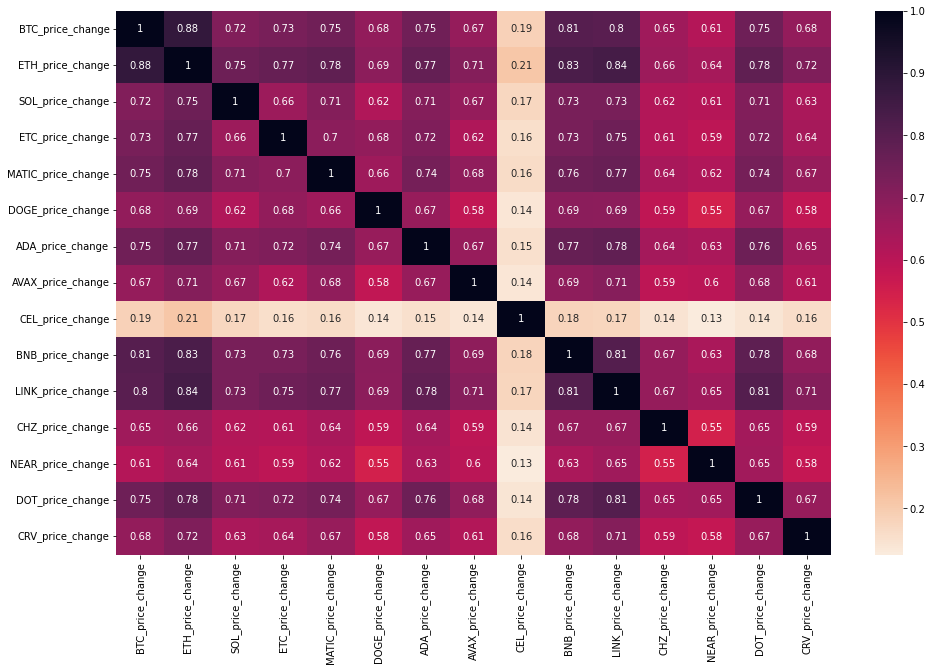

In [23]:
active_top_15_hour_price_change = pd.DataFrame(active_top_15_hour_price.loc[1:,'startTime'])
price_col_names = list(active_top_15_hour_price.columns)[1:]
for name in price_col_names:
    active_top_15_hour_price_change[f'{name}_change'] = pd.Series(active_top_15_hour_price[name].pct_change(1))[1:]

plt.figure(figsize=(16, 10))
sns.heatmap(active_top_15_hour_price_change.corr(), annot = True, cmap = sns.cm.rocket_r)

# TOP 10

## Minute data collection (Top 10)

In [139]:
start = 1577836800
end = 1659225600
timing_chunk = list(range(start, end, 5000*60))
btc_df = pd.DataFrame()
for duration in timing_chunk:
    start = duration
    end = duration + (5000*60) - 1
    historical = requests.get(f'https://ftx.com/api/markets/BTC-PERP/candles?resolution=60&start_time={start}&end_time={end}&limit=5005').json()
    historical = pd.DataFrame(historical['result'])
    btc_df = pd.concat([btc_df, historical], axis = 0)
btc_df.shape

(1357009, 7)

In [ ]:
# # To get all futures info
# all_futures = requests.get('https://ftx.com/api/futures').json()
# all_futures_df = pd.DataFrame(futures['result'])
# all_futures_df.set_index('name', inplace = True)
# all_futures_df.T

In [131]:
start = 1577836800
end = 1659225600
timing_chunk = list(range(start, end, 5000*60))
active_futures_pricing_data = pd.DataFrame()

for key in futures_active_top_10_list[1:]:
    temp = pd.DataFrame()
    for duration in timing_chunk:
        start = duration
        end = duration + (5000*60) - 1
        historical = requests.get(f'https://ftx.com/api/markets/{key}/candles?resolution=60&start_time={start}&end_time={end}&limit=5005').json()
        historical = pd.DataFrame(historical['result'])
        temp = pd.concat([temp, historical], axis = 0)
    futures_active_top_10_dct[key] = temp.copy()

In [155]:
temp_dct = futures_active_top_10_dct.copy()

In [160]:
for key, value in futures_active_top_10_dct.items():
    naming = f'Datasets/minute pricing/{key}_minute_pricing.csv'
    temp_df = value.copy()
    temp_df.to_csv(naming, index = False)

## Working on overall minute pricing data (Top 10)

In [271]:
futures_active_top_10_dct.keys()

dict_keys(['BTC-PERP', 'ETH-PERP', 'SOL-PERP', 'ETC-PERP', 'MATIC-PERP', 'FIL-PERP', 'OP-PERP', 'AVAX-PERP', 'XRP-PERP', 'ADA-PERP'])

### Concating all different assets

In [234]:
active_top_10_minute_volume = pd.DataFrame(futures_active_top_10_dct['BTC-PERP'][['startTime', 'volume']])
active_top_10_minute_volume.columns = ['startTime','BTC_volume']
active_top_10_minute_price = pd.DataFrame(futures_active_top_10_dct['BTC-PERP'][['startTime', 'open']])
active_top_10_minute_price.columns = ['startTime','BTC_price']

for key, value in futures_active_top_10_dct.items():
    if key == 'BTC-PERP':
        continue
    else:
        name = key.split('-')[0]
        temp_volume_df = value[['startTime', 'volume']]
        temp_volume_df.columns = ['startTime', f'{name}_vol']
        temp_price_df = value[['startTime', 'open']]
        temp_price_df.columns = ['startTime', f'{name}_price']
        if len(temp_volume_df) != len(temp_volume_df):
            print('Different length error')
            continue
        else:
            active_top_10_minute_volume = active_top_10_minute_volume.merge(temp_volume_df, on='startTime', how = 'inner')
            active_top_10_minute_price = active_top_10_minute_price.merge(temp_price_df, on='startTime', how = 'inner')
            # active_top_10_minute_volume = pd.concat([active_top_10_minute_volume, temp_volume_df], axis = 1)
            # active_top_10_minute_price = pd.concat([active_top_10_minute_price, temp_open_df], axis = 1)

# active_top_10_minute_price.to_csv('Datasets/minute pricing/overall_top_10_active_minute_pricing.csv', index=False)
# active_top_10_minute_volume.to_csv('Datasets/minute pricing/overall_top_10_active_minute_volume.csv', index=False)

In [210]:
active_top_10_minute_volume = pd.DataFrame(futures_active_top_10_dct['BTC-PERP'][['startTime', 'volume']])
active_top_10_minute_volume.columns = ['startTime','BTC_volume']
active_top_10_minute_price = pd.DataFrame(futures_active_top_10_dct['BTC-PERP'][['startTime', 'open']])
active_top_10_minute_price.columns = ['startTime','BTC_price']

for key, value in futures_active_top_10_dct.items():
    if key == 'BTC-PERP':
        continue
    else:
        name = key.split('-')[0]
        temp_volume_df = value[['startTime', 'volume']]
        temp_volume_df.columns = ['startTime', f'{name}_vol']
        temp_price_df = value[['startTime', 'open']]
        temp_price_df.columns = ['startTime', f'{name}_price']
        if len(temp_volume_df) != len(temp_volume_df):
            print('Different length error')
            continue
        else:
            active_top_10_minute_volume = active_top_10_minute_volume.merge(temp_volume_df, on='startTime', how = 'left')
            active_top_10_minute_price = active_top_10_minute_price.merge(temp_price_df, on='startTime', how = 'left')

active_top_10_minute_price.to_csv('Datasets/minute pricing/overall_top_10_active_minute_pricing_from2020start.csv', index=False)
active_top_10_minute_volume.to_csv('Datasets/minute pricing/overall_top_10_active_minute_volume_from2020start.csv', index=False)

#### price

In [309]:
# active_top_10_minute_price = pd.read_csv('Datasets/minute pricing/all_tokens_merged/overall_top_10_active_minute_pricing.csv')
active_top_10_minute_price_change = pd.DataFrame(active_top_10_minute_price.loc[1:,'startTime'])
price_col_names = list(active_top_10_minute_price.columns)[1:]
for name in price_col_names:
    active_top_10_minute_price_change[f'{name}_change'] = pd.Series(active_top_10_minute_price[name].pct_change(1))[1:]

In [318]:
active_top_10_minute_price_change.corr()

,BTC_price_change,ETH_price_change,SOL_price_change,ETC_price_change,MATIC_price_change,FIL_price_change,OP_price_change,AVAX_price_change,XRP_price_change,ADA_price_change
BTC_price_change,1.000000,0.875960,0.772471,0.676622,0.719521,0.628452,0.529667,0.755162,0.738899,0.758898
ETH_price_change,0.875960,1.000000,0.790622,0.708470,0.749162,0.647621,0.537326,0.772674,0.750380,0.769771
SOL_price_change,0.772471,0.790622,1.000000,0.671103,0.741119,0.634679,0.508307,0.803090,0.712865,0.767183
ETC_price_change,0.676622,0.708470,0.671103,1.000000,0.647746,0.582232,0.467845,0.660342,0.645467,0.671124
MATIC_price_change,0.719521,0.749162,0.741119,0.647746,1.000000,0.606955,0.479812,0.740620,0.675104,0.710915
FIL_price_change,0.628452,0.647621,0.634679,0.582232,0.606955,1.000000,0.424672,0.626980,0.602612,0.627475
OP_price_change,0.529667,0.537326,0.508307,0.467845,0.479812,0.424672,1.000000,0.504478,0.472420,0.506442
AVAX_price_change,0.755162,0.772674,0.803090,0.660342,0.740620,0.626980,0.504478,1.000000,0.703311,0.754372
XRP_price_change,0.738899,0.750380,0.712865,0.645467,0.675104,0.602612,0.472420,0.703311,1.000000,0.721620
ADA_price_change,0.758898,0.769771,0.767183,0.671124,0.710915,0.627475,0.506442,0.754372,0.721620,1.000000


<AxesSubplot:>

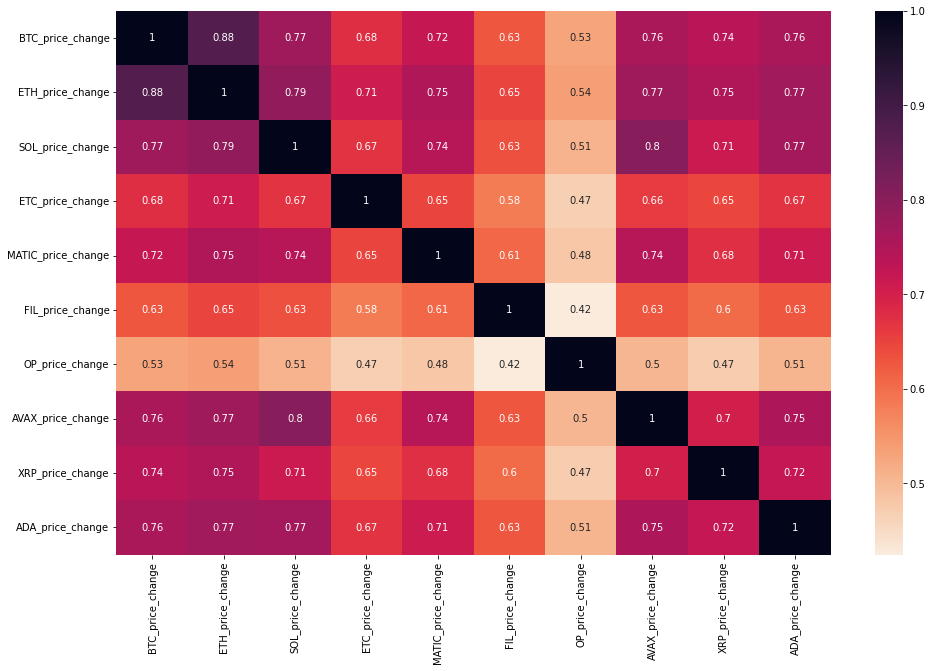

In [310]:
plt.figure(figsize=(16, 10))
sns.heatmap(active_top_10_minute_price_change.corr(), annot = True, cmap = sns.cm.rocket_r)

#### volume

In [317]:
active_top_10_minute_volume = pd.read_csv('Datasets/minute pricing/all_tokens_merged/overall_top_10_active_minute_volume.csv')
active_top_10_minute_volume_change = pd.DataFrame(active_top_10_minute_volume.loc[1:,'startTime'])
price_col_names = list(active_top_10_minute_volume.columns)[1:]
for name in price_col_names:
    active_top_10_minute_volume_change[f'{name}_change'] = pd.Series(active_top_10_minute_volume[name].pct_change(1))[1:]
active_top_10_minute_volume_change.corr()

,BTC_volume_change,ETH_vol_change,SOL_vol_change,ETC_vol_change,MATIC_vol_change,FIL_vol_change,OP_vol_change,AVAX_vol_change,XRP_vol_change,ADA_vol_change
BTC_volume_change,1.000000,0.002103,0.003688,0.001442,0.001981,0.014867,0.000988,0.001007,0.004198,0.005648
ETH_vol_change,0.002103,1.000000,0.008533,0.006118,0.031330,0.017301,0.002243,0.002815,0.024953,0.005422
SOL_vol_change,0.003688,0.008533,1.000000,0.024801,0.008146,0.006412,0.003730,0.011271,0.002223,0.009528
ETC_vol_change,0.001442,0.006118,0.024801,1.000000,0.015971,0.026491,0.006077,0.007587,0.017370,0.010691
MATIC_vol_change,0.001981,0.031330,0.008146,0.015971,1.000000,0.013527,0.005881,0.004164,0.031195,0.008609
FIL_vol_change,0.014867,0.017301,0.006412,0.026491,0.013527,1.000000,0.008805,0.007385,0.001187,0.004171
OP_vol_change,0.000988,0.002243,0.003730,0.006077,0.005881,0.008805,1.000000,0.002194,0.026524,0.003607
AVAX_vol_change,0.001007,0.002815,0.011271,0.007587,0.004164,0.007385,0.002194,1.000000,0.001896,0.024929
XRP_vol_change,0.004198,0.024953,0.002223,0.017370,0.031195,0.001187,0.026524,0.001896,1.000000,0.002161
ADA_vol_change,0.005648,0.005422,0.009528,0.010691,0.008609,0.004171,0.003607,0.024929,0.002161,1.000000


<AxesSubplot:>

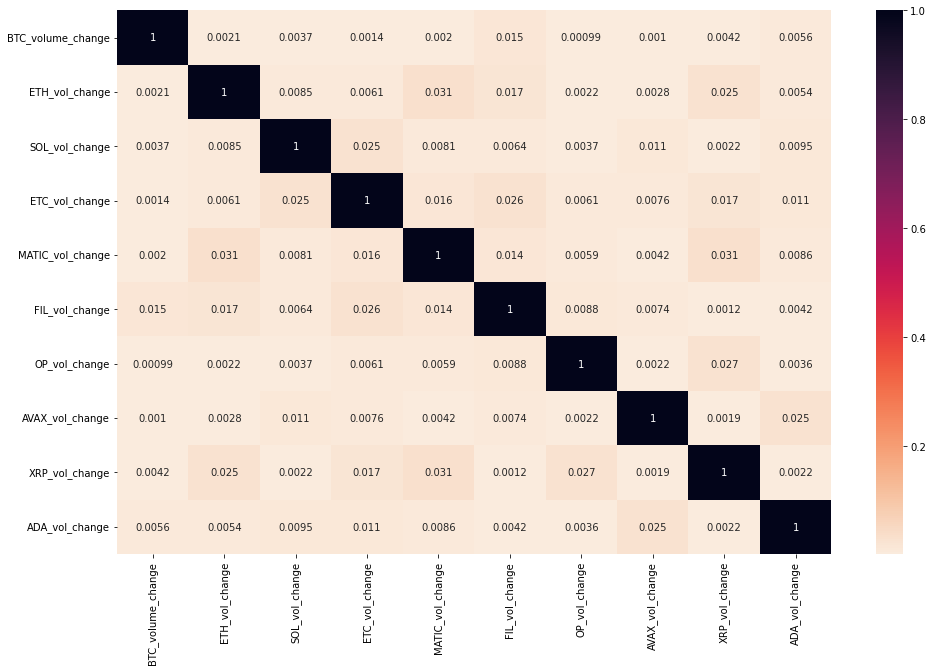

In [313]:
plt.figure(figsize=(16, 10))
sns.heatmap(active_top_10_minute_volume_change.corr(), annot = True, cmap = sns.cm.rocket_r)

# Furthering approach to account for longer duration data

Realization that it is difficult to mirror trading on seconds/milliseconds as I will not have the computational power to do the trades - Cannot mirror the inefficiencies of market as a strategy to turn a profit (We will consider other trading strategies instead)

# Top 15 (Part 2)

## Daily data collection

In [13]:
futures_active_top_15_list = futures_active_and_longstanding_top_15_list
futures_active_top_15_dct = {}
for i in futures_active_and_longstanding_top_15_list:
    futures_active_top_15_dct[i] = ''

In [12]:
start = 1614556800
end = 1659916800
timing_chunk = list(range(start, end, 5000*86400))
btc_df = pd.DataFrame()
for duration in timing_chunk:
    start = duration
    end = duration + (5000*86400) - 1
    historical = requests.get(f'https://ftx.com/api/markets/BTC-PERP/candles?resolution=86400&start_time={start}&end_time={end}&limit=5005').json()
    historical = pd.DataFrame(historical['result'])
    btc_df = pd.concat([btc_df, historical], axis = 0)
btc_df.shape

(531, 7)

In [14]:
# Ensuring flow of hours were successful
(btc_df['startTime'].apply(lambda x: pd.to_datetime(x)) - btc_df['startTime'].shift(1).apply(lambda x: pd.to_datetime(x))).value_counts()

1 days    530
Name: startTime, dtype: int64

In [15]:
start = 1614556800
end = 1659916800
timing_chunk = list(range(start, end, 5000*86400))
active_futures_pricing_data = pd.DataFrame()

for key in futures_active_top_15_list:
    temp = pd.DataFrame()
    for duration in timing_chunk:
        start = duration
        end = duration + (5000*86400) - 1
        historical = requests.get(f'https://ftx.com/api/markets/{key}/candles?resolution=86400&start_time={start}&end_time={end}&limit=5005').json()
        historical = pd.DataFrame(historical['result'])
        temp = pd.concat([temp, historical], axis = 0)
    futures_active_top_15_dct[key] = temp.copy()

In [16]:
temp_dct = futures_active_top_15_dct.copy()

In [18]:
for key, value in futures_active_top_15_dct.items():
    naming = f'Datasets/daily pricing/{key}_daily_pricing.csv'
    temp_df = value.copy()
    temp_df.to_csv(naming, index = False)

## Working on overall daily pricing data 

In [20]:
# active_top_10_minute_volume = pd.DataFrame(futures_active_top_10_dct['BTC-PERP'][['startTime', 'volume']])
# active_top_10_minute_volume.columns = ['startTime','BTC_volume']
active_top_15_daily_price = pd.DataFrame(futures_active_top_15_dct['BTC-PERP'][['startTime', 'open']])
active_top_15_daily_price.columns = ['startTime','BTC_price']

for key, value in futures_active_top_15_dct.items():
    if key == 'BTC-PERP':
        continue
    else:
        name = key.split('-')[0]
        # temp_volume_df = value[['startTime', 'volume']]
        # temp_volume_df.columns = ['startTime', f'{name}_vol']
        temp_price_df = value[['startTime', 'open']]
        temp_price_df.columns = ['startTime', f'{name}_price']
        if len(temp_price_df) != len(temp_price_df):
            print('Different length error')
            continue
        else:
            # active_top_10_hour_volume = active_top_10_hour_volume.merge(temp_volume_df, on='startTime', how = 'inner')
            active_top_15_daily_price = active_top_15_daily_price.merge(temp_price_df, on='startTime', how = 'inner')
            # active_top_10_minute_volume = pd.concat([active_top_10_minute_volume, temp_volume_df], axis = 1)
            # active_top_10_minute_price = pd.concat([active_top_10_minute_price, temp_open_df], axis = 1)

# active_top_10_minute_price.to_csv('Datasets/minute pricing/overall_top_10_active_minute_pricing.csv', index=False)
# active_top_10_minute_volume.to_csv('Datasets/minute pricing/overall_top_10_active_minute_volume.csv', index=False)

In [21]:
active_top_15_daily_price.head(3)

,startTime,BTC_price,ETH_price,SOL_price,ETC_price,MATIC_price,AVAX_price,BNB_price,ADA_price,NEAR_price,LINK_price,DOT_price,DOGE_price,FIL_price,ATOM_price,FTM_price
0,2021-03-09T00:00:00+00:00,52501.0,1836.0,13.6675,11.7295,0.217735,25.592,240.6600,1.121135,4.58125,31.8875,35.080,0.063198,41.630,19.4655,0.45175
1,2021-03-10T00:00:00+00:00,54962.0,1875.9,14.9300,12.4125,0.300567,34.502,294.0350,1.201060,5.42000,31.5370,38.376,0.058112,42.005,21.2135,0.53170
2,2021-03-11T00:00:00+00:00,55968.0,1796.6,14.2575,11.9650,0.287930,29.703,278.7375,1.132195,5.33550,29.9440,37.665,0.055991,42.505,19.6590,0.45860


#### price

<AxesSubplot:>

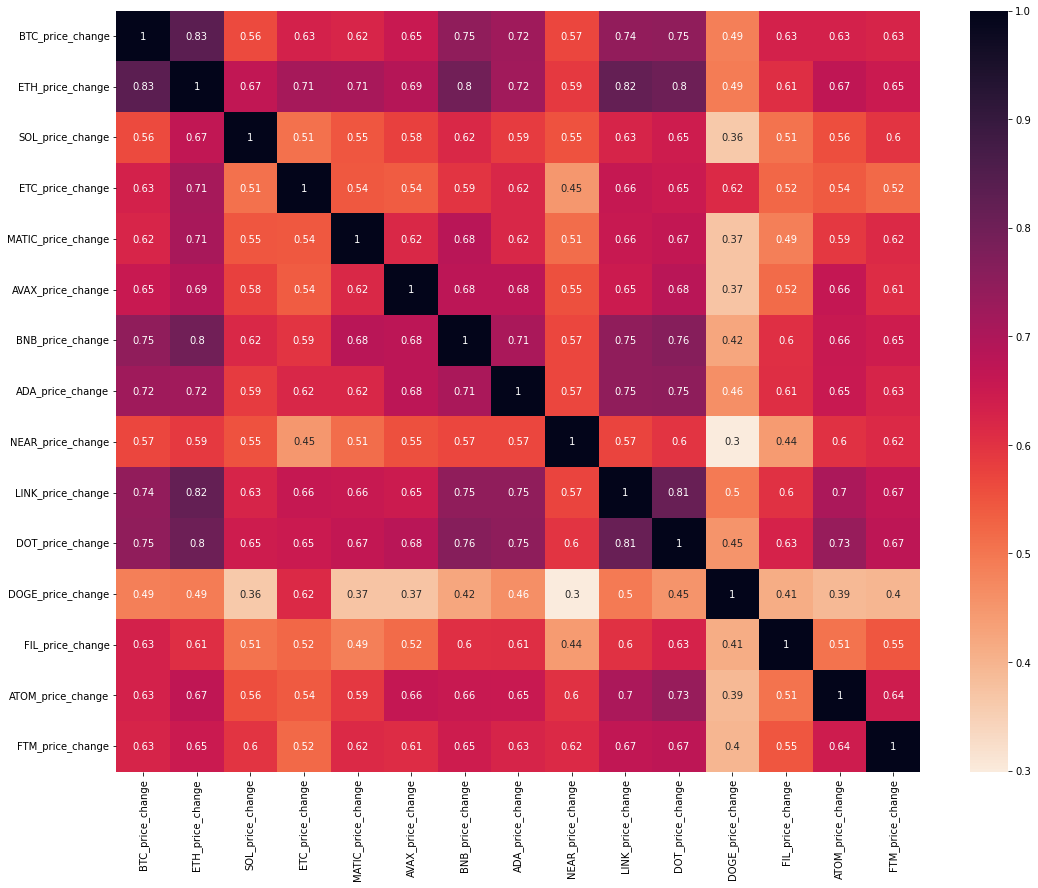

In [22]:
active_top_15_daily_price_change = pd.DataFrame(active_top_15_daily_price.loc[1:,'startTime'])
price_col_names = list(active_top_15_daily_price.columns)[1:]
for name in price_col_names:
    active_top_15_daily_price_change[f'{name}_change'] = pd.Series(active_top_15_daily_price[name].pct_change(1))[1:]

plt.figure(figsize=(18, 14))
sns.heatmap(active_top_15_daily_price_change.corr(), annot = True, cmap = sns.cm.rocket_r)

Note - Daily data looks bad

## 4 Hours data collection

In [33]:
futures_active_top_15_list = futures_active_and_longstanding_top_15_list
futures_active_top_15_dct = {}
for i in futures_active_and_longstanding_top_15_list:
    futures_active_top_15_dct[i] = ''

In [31]:
start = 1614556800
end = 1659916800
timing_chunk = list(range(start, end, 5000*14400))
btc_df = pd.DataFrame()
for duration in timing_chunk:
    start = duration
    end = duration + (5000*14400) - 1
    historical = requests.get(f'https://ftx.com/api/markets/BTC-PERP/candles?resolution=14400&start_time={start}&end_time={end}&limit=5005').json()
    historical = pd.DataFrame(historical['result'])
    btc_df = pd.concat([btc_df, historical], axis = 0)
btc_df.shape

(3183, 7)

In [32]:
# Ensuring flow of hours were successful
(btc_df['startTime'].apply(lambda x: pd.to_datetime(x)) - btc_df['startTime'].shift(1).apply(lambda x: pd.to_datetime(x))).value_counts()

0 days 04:00:00    3182
Name: startTime, dtype: int64

In [34]:
start = 1614556800
end = 1659916800
timing_chunk = list(range(start, end, 5000*14400))
active_futures_pricing_data = pd.DataFrame()

for key in futures_active_top_15_list:
    temp = pd.DataFrame()
    for duration in timing_chunk:
        start = duration
        end = duration + (5000*14400) - 1
        historical = requests.get(f'https://ftx.com/api/markets/{key}/candles?resolution=14400&start_time={start}&end_time={end}&limit=5005').json()
        historical = pd.DataFrame(historical['result'])
        temp = pd.concat([temp, historical], axis = 0)
    futures_active_top_15_dct[key] = temp.copy()

In [35]:
temp_dct = futures_active_top_15_dct.copy()

In [37]:
for key, value in futures_active_top_15_dct.items():
    naming = f'Datasets/4 hour pricing/{key}_4_hour_pricing.csv'
    temp_df = value.copy()
    temp_df.to_csv(naming, index = False)

## Working on overall 4 hours pricing data

In [38]:
# active_top_10_minute_volume = pd.DataFrame(futures_active_top_10_dct['BTC-PERP'][['startTime', 'volume']])
# active_top_10_minute_volume.columns = ['startTime','BTC_volume']
active_top_15_4_hour_price = pd.DataFrame(futures_active_top_15_dct['BTC-PERP'][['startTime', 'open']])
active_top_15_4_hour_price.columns = ['startTime','BTC_price']

for key, value in futures_active_top_15_dct.items():
    if key == 'BTC-PERP':
        continue
    else:
        name = key.split('-')[0]
        # temp_volume_df = value[['startTime', 'volume']]
        # temp_volume_df.columns = ['startTime', f'{name}_vol']
        temp_price_df = value[['startTime', 'open']]
        temp_price_df.columns = ['startTime', f'{name}_price']
        if len(temp_price_df) != len(temp_price_df):
            print('Different length error')
            continue
        else:
            # active_top_10_hour_volume = active_top_10_hour_volume.merge(temp_volume_df, on='startTime', how = 'inner')
            active_top_15_4_hour_price = active_top_15_4_hour_price.merge(temp_price_df, on='startTime', how = 'inner')
            # active_top_10_minute_volume = pd.concat([active_top_10_minute_volume, temp_volume_df], axis = 1)
            # active_top_10_minute_price = pd.concat([active_top_10_minute_price, temp_open_df], axis = 1)

# active_top_10_minute_price.to_csv('Datasets/minute pricing/overall_top_10_active_minute_pricing.csv', index=False)
# active_top_10_minute_volume.to_csv('Datasets/minute pricing/overall_top_10_active_minute_volume.csv', index=False)

In [39]:
active_top_15_4_hour_price.head(3)

,startTime,BTC_price,ETH_price,SOL_price,ETC_price,MATIC_price,AVAX_price,BNB_price,ADA_price,NEAR_price,LINK_price,DOT_price,DOGE_price,FIL_price,ATOM_price,FTM_price
0,2021-03-09T08:00:00+00:00,53631.0,1817.5,13.9125,12.0390,0.225162,25.262,243.3175,1.128370,5.3690,31.032,35.359,0.058370,41.665,19.5655,0.44230
1,2021-03-09T12:00:00+00:00,54331.0,1830.9,14.3650,12.1520,0.241835,28.241,269.2550,1.194090,5.3780,31.306,36.370,0.057345,42.040,20.1115,0.47395
2,2021-03-09T16:00:00+00:00,54180.0,1837.0,14.7025,12.1475,0.245000,29.625,276.9850,1.177895,5.5215,30.831,36.280,0.057207,42.135,19.9280,0.52180


### price

<AxesSubplot:>

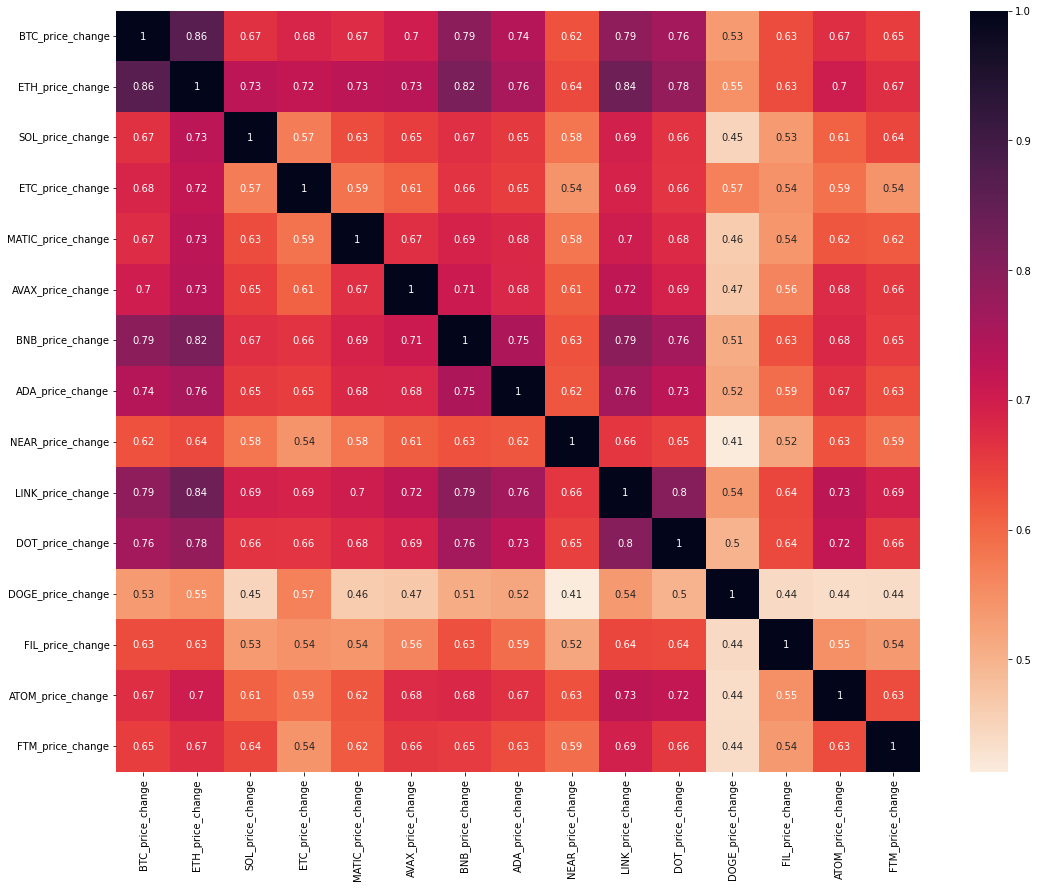

In [40]:
active_top_15_4_hour_price_change = pd.DataFrame(active_top_15_4_hour_price.loc[1:,'startTime'])
price_col_names = list(active_top_15_4_hour_price.columns)[1:]
for name in price_col_names:
    active_top_15_4_hour_price_change[f'{name}_change'] = pd.Series(active_top_15_4_hour_price[name].pct_change(1))[1:]

plt.figure(figsize=(18, 14))
sns.heatmap(active_top_15_4_hour_price_change.corr(), annot = True, cmap = sns.cm.rocket_r)

# Conclusion

We will be using hourly data since that corresponds to the highest correlated data across the board